In [271]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import torch
# from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


In [272]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

## Utilities

From Exercise 03, re-use the training loop. In addition, we provide you the following function for evaluating the classification accuracy of a pytorch classifier.

In [273]:
def evaluate_classification(model: nn.Module, criterion: nn.modules.loss._Loss, test_loader: DataLoader):

    """
        Evaluates a classification model by computing loss and classification accuracy on a test set.

        Parameters:
        -----------
        model : pytorch model.
        test_loader : pytorch Dataloader containing the test data.
        criterion: Loss function.

    """

    model.eval()

    val_loss, correct = 0, 0
    for data, target in test_loader:
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(test_loader)

    accuracy = 100. * correct.to(torch.float32) / len(test_loader.dataset)

    return val_loss, accuracy



In [274]:
def train(model:nn.Module, train_loader: DataLoader, optimizer: torch.optim.Optimizer, criterion: nn.modules.loss._Loss):
    """
        Basic training loop for a pytorch model.

        Parameters:
        -----------
        model : pytorch model.
        train_loader : pytorch Dataloader containing the training data.
        optimizer: Optimizer for gradient descent. 
        criterion: Loss function. 

    """
        
    # Set model to training mode
    model.train()
    epoch_loss = 0
    n_batches = len(train_loader)

    # Loop over each batch from the training set
    for (data, target) in train_loader:
    
        # Copy data to device
        data = data.to(DEVICE)
        target = target.to(DEVICE)

        # set optimizer to zero grad to remove previous gradients
        optimizer.zero_grad() 

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # get gradients
        loss.backward()
        
        # gradient descent
        optimizer.step()
        
        epoch_loss += loss.data.item()

    return epoch_loss / n_batches


# MNIST

### Loading the data

We want to use a common dataset in machine learning, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of hand-written digits. This is already contained in pytorch, so we don't need to generate it ourselfs and can just download it and store it in a DataLoader.

The dataset is contained in the torchvision package, which we can add to our environment using 

 conda install -c pytorch torchvision 

In [275]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [276]:
batch_size = 32

train_dataset_full = datasets.MNIST('./data', 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

test_dataset_full = datasets.MNIST('./data', 
                                    train=False, 
                                    transform=transforms.ToTensor())

# The full dataset contains 60000 samples - this is too much for this Exercise. We therefore choose a subset of 1000 samples randomly chosen.
n_samples_train = 1000

 # get indices for training and test set
ids = np.arange(len(train_dataset_full))
np.random.shuffle(ids)
train_dataset = Subset(train_dataset_full, ids[:n_samples_train])

# get indices for training and test set
n_samples_test = 200
ids = np.arange(len(test_dataset_full))
np.random.shuffle(ids)
test_dataset = Subset(test_dataset_full, ids[:n_samples_test])

train_loader = DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

print("The length of train data is:",len(train_dataset))
print("The length of test data is:",len(test_dataset))


The length of train data is: 1000
The length of test data is: 200


Let's have a look at a few samples from the training dataset.

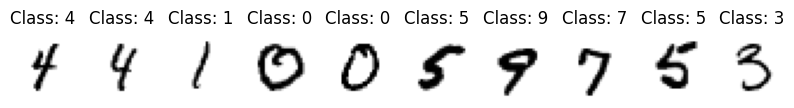

In [277]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i, idata in enumerate(train_dataset.indices[:10]):

    image = train_dataset.dataset[idata][0]
    label =  train_dataset.dataset[idata][1]
    
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(image.numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(label))



## MLP

In [278]:
class MLPClassifier(nn.Module):
    def __init__(self, n_units: list, activation= nn.ReLU()):
        """
            Simple multi-layer perceptron (MLP).

            Parameters:
            -----------
            n_units : List of integers specifying the dimensions of input and output and the hidden layers.
            activation: Activation function used for non-linearity. 


            Example:
            -----------

            dim_hidden = 100
            dim_in = 2
            dim_out = 5

            # MLP with input dimension 2, output dimension 5, and 4 hidden layers of dimension 100
            model = MLP([dim_in,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_hidden,
                        dim_out],activation=nn.ReLU()).to(DEVICE)

        """
        super().__init__()

        # Get input and output dimensions
        dims_in = n_units[:-1]
        dims_out = n_units[1:]

        layers = []
        layers.append(nn.Flatten(start_dim=1, end_dim=-1))
        # Add linear layers (and activation function after all layers except the final one)
        for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            # layers.append(nn.Flatten(start_dim=1, end_dim=-1))
            layers.append(torch.nn.Linear(dim_in, dim_out))
            
            if i < len(n_units) - 2:
                layers.append(activation)
        

        self._layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        """
            MLP forward pass

        """
        return self._layers(x)
    
    def count_parameters(self): 
        """
            Counts the number of trainable parameters.

        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [279]:
image = train_dataset.dataset[idata][0]
label =  train_dataset.dataset[idata][1]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
3


In [ ]:
learning_rate = 3e-4
epochs = 1000
losses = []
model = MLPClassifier([28*28, 512, 512, 256, 10],activation=nn.ReLU()).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:

# model(image)
i = 0
while i < epochs:
  loss = train(model, train_loader, optimizer, criterion)
  losses.append(loss)
  if i % 10 == 0:
    print(f"finished epoch {i}")
  i += 1


finished epoch 0
finished epoch 10
finished epoch 20
finished epoch 30
finished epoch 40
finished epoch 50
finished epoch 60
finished epoch 70
finished epoch 80
finished epoch 90
finished epoch 100
finished epoch 110
finished epoch 120
finished epoch 130
finished epoch 140
finished epoch 150
finished epoch 160
finished epoch 170
finished epoch 180
finished epoch 190
finished epoch 200
finished epoch 210
finished epoch 220
finished epoch 230
finished epoch 240
finished epoch 250
finished epoch 260
finished epoch 270
finished epoch 280
finished epoch 290
finished epoch 300
finished epoch 310
finished epoch 320
finished epoch 330
finished epoch 340
finished epoch 350
finished epoch 360
finished epoch 370
finished epoch 380
finished epoch 390
finished epoch 400
finished epoch 410
finished epoch 420
finished epoch 430
finished epoch 440
finished epoch 450
finished epoch 460
finished epoch 470
finished epoch 480
finished epoch 490
finished epoch 500
finished epoch 510
finished epoch 520
fini

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_40272/3992259843.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(fontsize=5)


(1.2176378284181868, tensor(91.5000))


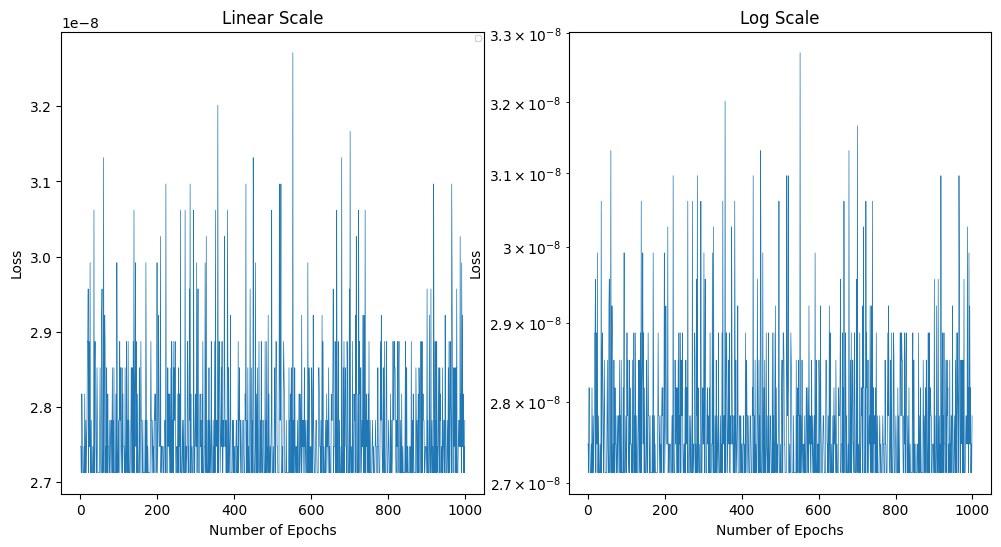

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(losses, linewidth=0.5)
axes[0].legend(fontsize=5)
axes[0].set_title("Linear Scale")
axes[0].set_xlabel("Number of Epochs")
axes[0].set_ylabel("Loss")

axes[1].plot(losses, linewidth=0.5)

axes[1].set_yscale('log')  # Set y-axis to log scale
axes[1].set_xlabel("Number of Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title('Log Scale')

print(evaluate_classification(model, criterion, test_loader))


# plt.title("Loss over MLP training")
plt.show()

## CNN
Here is an idea of how to structure the CNN

In [283]:
import torch.nn as nn


class CNN(nn.Module):
    def __init__(
        self,
        in_channels=1,
        out_channels=16,
        out_channels2=32,
        kernel_size=5,
        kernel_size_max_pool=2,
        stride=1,
        padding=2,
    ):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.linear = nn.Linear(30976, 10)

    def forward(self, x):

        # print("Shape inside forward:", x.shape) 
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [284]:
# image

In [285]:


learning_rate = 1e-5
CNNmodel = CNN(in_channels=16, out_channels=16, kernel_size=5, kernel_size_max_pool=2, stride=1, padding=2).to(DEVICE)
optimizer = optim.Adam(CNNmodel.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
losses = []

In [ ]:
i = 0
epochs = 1000
while i < epochs:
  loss = train(CNNmodel, train_loader, optimizer, criterion)
  losses.append(loss)
  if i % 10 == 0:
    print(f"finished epoch {i}")
  i += 1


finished epoch 0
finished epoch 10
finished epoch 20
finished epoch 30
finished epoch 40
finished epoch 50
finished epoch 60
finished epoch 70
finished epoch 80
finished epoch 90
finished epoch 100
finished epoch 110
finished epoch 120
finished epoch 130
finished epoch 140
finished epoch 150
finished epoch 160
finished epoch 170
finished epoch 180
finished epoch 190
finished epoch 200
finished epoch 210
finished epoch 220
finished epoch 230
finished epoch 240
finished epoch 250
finished epoch 260
finished epoch 270
finished epoch 280
finished epoch 290
finished epoch 300
finished epoch 310
finished epoch 320
finished epoch 330
finished epoch 340
finished epoch 350
finished epoch 360
finished epoch 370
finished epoch 380
finished epoch 390
finished epoch 400
finished epoch 410
finished epoch 420
finished epoch 430
finished epoch 440
finished epoch 450
finished epoch 460
finished epoch 470
finished epoch 480
finished epoch 490
finished epoch 500
finished epoch 510
finished epoch 520
fini

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_40272/1670551069.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(fontsize=5)


(1.7150782580873007, tensor(93.5000))


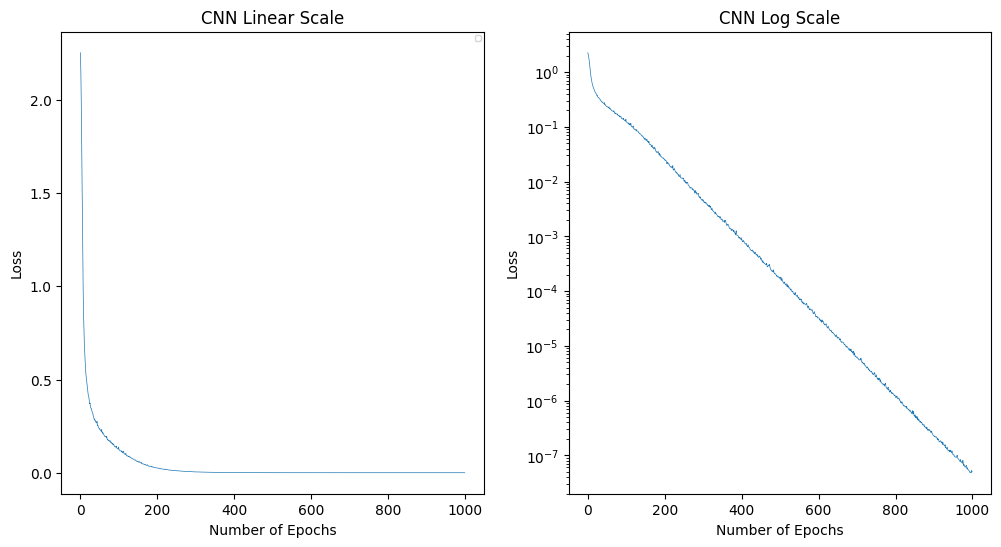

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(losses, linewidth=0.5)
axes[0].legend(fontsize=5)
axes[0].set_title("CNN Linear Scale")
axes[0].set_xlabel("Number of Epochs")
axes[0].set_ylabel("Loss")

axes[1].plot(losses, linewidth=0.5)

axes[1].set_yscale('log')  # Set y-axis to log scale
axes[1].set_xlabel("Number of Epochs")
axes[1].set_ylabel("Loss")
axes[1].set_title('CNN Log Scale')

print(evaluate_classification(CNNmodel, criterion, test_loader))


# plt.title("Loss over MLP training")
plt.show()

In [288]:
# print(image.shape)
# input_data = image.unsqueeze(1)  # Shape becomes [1, 1, 28, 28]
# print(input_data.shape)
# CNNmodel(input_data)